

<center><table>
<tr>

<th> <img src= "INL1.png",align="middle",style="width: 10000px;"/> </th>
</tr>
<tr>
<th> <img src="PennNucDataCenter.jpeg"  ,align="middle", style="width: 500px;"/> </th>
</tr>
<center><table>

# <center>Nuclear-Powered Data Centers Economic Optimization Strategy</center>

#### Expected Outcome
- A journal paper evaluating <u>the economic threshold points</u> identifying the conditions under which user requirements would be better suited by a large, small, or micro-reactor. The use case will be focused on data centers and will provide INL with the credential to stake a claim as a leader in nuclear for data center research.

- With a framework on hand, the lab could then leverage its expertise to offer advisory support for the various data centers considering nuclear energy. Further, with interest growing in this area, it is possible that DOE-NE would sponsor research on coupling nuclear reactors with data centers. INL would be well positioned to lead such R&D activities.

#### Activity
- A framework is proposed to evaluate the **economic tradeoff** between large, small, and micro-reactors. 
- The intent is to map out ‘threshold values’ under a given set of requirements 
  - energy demand size
  - reliability 
  
- The framework would parametrize a set of important economic variables to quantifiably differentiate the different reactor classes. 
  - nuclear capacity
  - diseconomies of scale, 
   - economies of mass production, 
   - speed of deployment, 
   - downtime intervals  



### Required Imports

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from src import *
from scipy import signal
import sk_dsp_comm.sigsys as ss



/tmp/ipykernel_1982073/3904854679.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## The schedule for one reactor

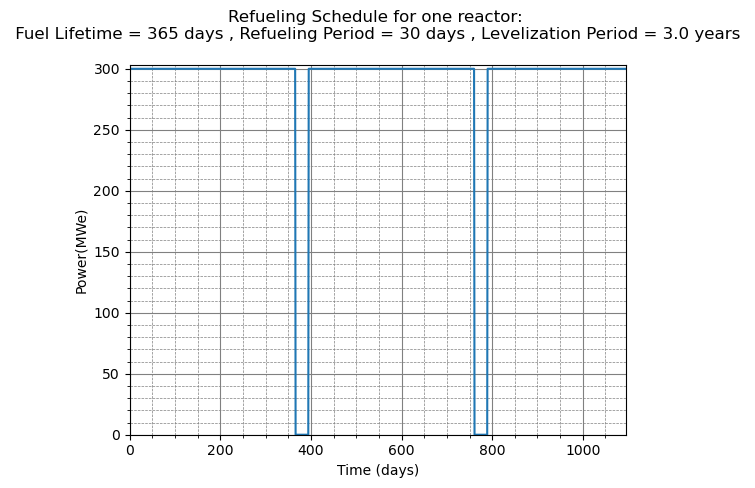

In [67]:
power = 300 # MWe
fuel_lifetime = 1*365 # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 3*365 # in days
inital_delay = 0

t_list = []
P_list = []
for time in range(levelization_period+1):
    P = calculate_duty_cycle( inital_delay, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list.append(P)


plt.plot(t_list, P_list)
plt.xlim(0, levelization_period)
plt.ylim(0, 1.01*power)
plt.xlabel('Time (days)')
plt.ylabel('Power(MWe)')

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()


plt.title(f"Refueling Schedule for one reactor: \n Fuel Lifetime = {np.round(fuel_lifetime, 1)} days , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.show()

## The schedule for 2 reactors
The second reactor should start after the first reactor with a delay equals 1 refueling period. This way we guarantee that:
1. Both reactors will never be off at the same time, 
2- Use the full power of the two reactors ASAP


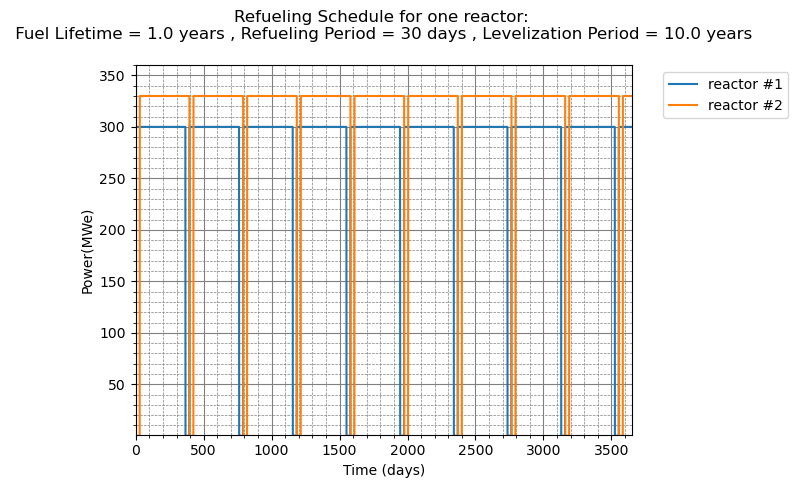

In [57]:
power = 300 # MWe
fuel_lifetime = 1*365 # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 10*365 # in days
inital_delay1 = 0
inital_delay2 = refueling_period 

t_list = []
P_list1 = []
P_list2 = []
for time in range(levelization_period+1):
    P1 = calculate_duty_cycle( inital_delay1, fuel_lifetime, refueling_period, levelization_period, power, time)
    t_list.append(time)
    P_list1.append(P1)
    P2 = calculate_duty_cycle( inital_delay2, fuel_lifetime, refueling_period, levelization_period, 1.1*power, time) # I change the power her for visualization
    if P2 == 0:
        if P1 ==0:
            print("WARNING: P2 = 0 and P1 =0")
    P_list2.append(P2)

plt.plot(t_list, P_list1, label = "reactor #1")
plt.plot(t_list, P_list2, label = "reactor #2")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlim(0, levelization_period)
plt.ylim(1, 1.2*power)
plt.xlabel('Time (days)')
plt.ylabel('Power(MWe)')

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.title(f"Refueling Schedule for one reactor: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  \le \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 4

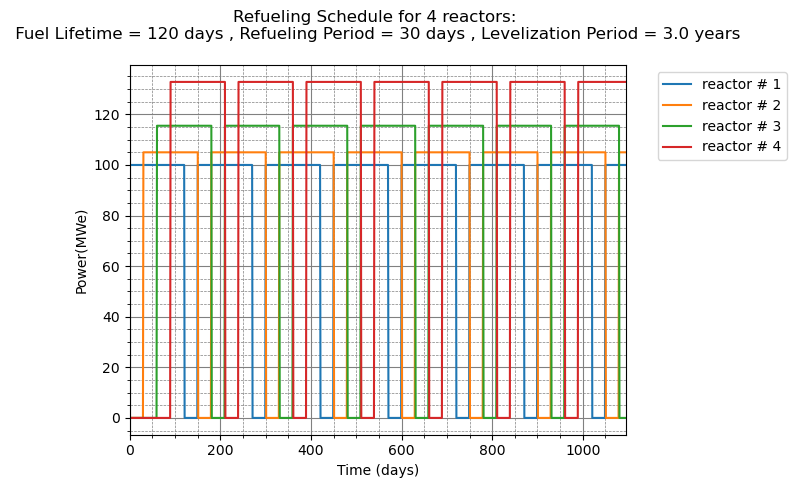

In [75]:
power = 100 # MWe
fuel_lifetime = int(4*30) # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 3*365 # in days

num_reactors = 4

initial_delay_list =list(refueling_period*np.linspace(0,  num_reactors-1, num_reactors) )
P_list_tot = []
for i in range(len(initial_delay_list)):
    
    delay = initial_delay_list[i] 
    power = power *(1+ i *0.05) # just for visualization
    
    t_list = []
    P_list = []

    for time in range(levelization_period+1):
       
        P = calculate_duty_cycle( int( delay), fuel_lifetime, refueling_period, levelization_period, power, time)
      
        t_list.append(time)
        P_list.append(P)

    P_list_tot.append(P_list)

    plt.plot(t_list, P_list, label = f"reactor # {i+1}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlim(0, levelization_period)
    plt.xlabel('Time (days)')
    plt.ylabel('Power(MWe)')

    plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime, 1)} days , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()
    
plt.show()


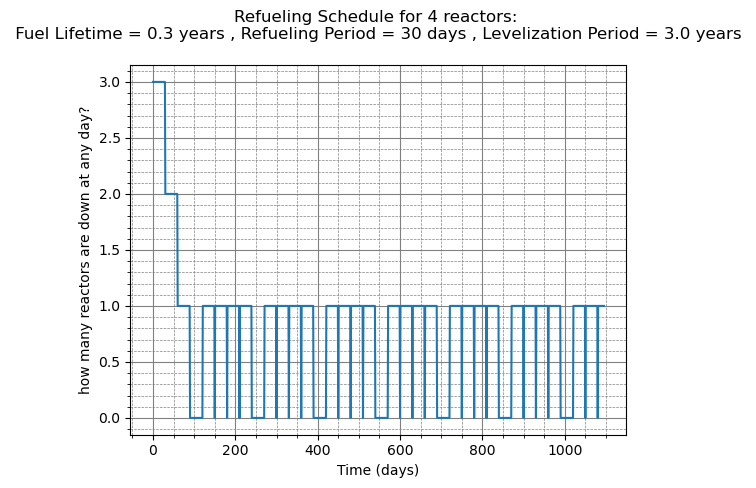

In [76]:
P_list_tot_array = (np.vstack(P_list_tot))
reactors_down_list = []
for n in range(P_list_tot_array.shape[1]):
    arr = P_list_tot_array[:,n]
    reactors_down_list.append(np.count_nonzero(arr==0))

plt.plot(t_list,  reactors_down_list) 
plt.xlabel('Time (days)')
plt.ylabel('how many reactors are down at any day?')
plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime/365, 1)} years , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")

plt.grid(which='major', color='grey', linewidth=0.8)
plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
plt.minorticks_on()

plt.show()

## The schedule for multiple reactors : $ number \, of \, reactors  > \frac{fuel \, Lifetime}{Refueling \, Period} $

An example for visualization (not realistic):
- fuel lifetime = 4 months
- refueling period = 1 months
- number of reactors = 7

Since the total number of refueling  = 1 months * 7 reactors = 7 months which is longer than the fuel lifetime which is 4 months, this means that more than one reactor has to be down at sometime

Using increments of 1 months (the refueling period), all the reactors have to be refueled within one cycle.
The number of reactos to be refueled at the same time $= \frac{7}{4}  = 1\frac{3}{4} $

-Therefore, 2 reactors will be refueled each month (in the first 3 months) and 1 reactor is refueled in the 4th month

<br>


This can be formulated as follows
- $number \, of\, reactors \, down \, at \, one\,  refueling\, period \in  [ Ceiling[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}] \, , \, Floor[ \frac {num \, of \, reactors \, \times \, refueling \, period}{ fuel \, lifetime}]] $

    - The number of refueling period where the ceiling value is taken is :  $ \frac {modulus(num \, of \, reactors \, \times \, refueling \, period \, , \, refueling \, period) }{refueling \, period}$

In [103]:
power = 100 # MWe
fuel_lifetime = int(4*30) # days
refueling_period = 30 #days. In this work, the refueling period has to be at least 2 days
levelization_period = 3*365 # in days

num_reactors = 7
num_reactors_down_max = int(np.ceil(num_reactors * refueling_period/fuel_lifetime))
num_reactors_down_min = int(np.floor(num_reactors * refueling_period/fuel_lifetime))

# how many times the celing value is used
num_reactors_down_max_freq = int(np.ceil((num_reactors * refueling_period )% fuel_lifetime)/refueling_period) 
num_reactors_down_min_freq = int(fuel_lifetime /refueling_period)- num_reactors_down_max_freq

initial_delay_list1 = [num_reactors_down_max ]*num_reactors_down_max_freq
initial_delay_list2 = [num_reactors_down_min ]*num_reactors_down_min_freq
initial_delay_list = initial_delay_list1 + initial_delay_list2
initial_delay_list 
# assert len(initial_delay_list ) == int(fuel_lifetime/refueling_period ) , "There is an assertion error. review!"


# initial_delay_list =list(refueling_period*np.linspace(0,  num_reactors-1, num_reactors) )
# P_list_tot = []
# for i in range(len(initial_delay_list)):
    
#     delay = initial_delay_list[i] 
#     power = power *(1+ i *0.05) # just for visualization
    
#     t_list = []
#     P_list = []

#     for time in range(levelization_period+1):
       
#         P = calculate_duty_cycle( int( delay), fuel_lifetime, refueling_period, levelization_period, power, time)
      
#         t_list.append(time)
#         P_list.append(P)

#     P_list_tot.append(P_list)

#     plt.plot(t_list, P_list, label = f"reactor # {i+1}")
#     plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#     plt.xlim(0, levelization_period)
#     plt.xlabel('Time (days)')
#     plt.ylabel('Power(MWe)')

#     plt.title(f"Refueling Schedule for {num_reactors} reactors: \n Fuel Lifetime = {np.round(fuel_lifetime, 1)} days , Refueling Period = {refueling_period} days , Levelization Period = {np.round(levelization_period/365, 1)} years \n")
# plt.grid(which='major', color='grey', linewidth=0.8)
# plt.grid(which='minor', color='grey', linestyle='dashed', linewidth=0.5)
# plt.minorticks_on()
    
# plt.show()


[2, 2, 2, 1]